In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates
import datetime
import math

import torch
from torch.utils.data import DataLoader, Dataset

import torch.nn.init as init

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import mean_squared_error
from scipy import signal


import sys

sys.path.append('../src')
from read_dataset import data_from_name
from model import *
from tools import *
from train import *

import os

# from pydmd import DMD
import pickle
import seaborn as sns
sns.set_style("white")


## Effect of $\tau$

In [2]:
scale = 0.25
lags = 10
freq_list =[1,2,4,10,20]
error_list = []
embeddings_list = []


for freq in freq_list:
    # load data
    X, Xclean, m, n = data_from_name("climate", freq=freq, start_year=1990, end_year= 2030, tropical=0, scale=scale)

    print(type(X))

    X = torch.from_numpy(X).float().contiguous()
    X = add_channels(X)
    print(X.min())
    print(X.max())
    print(X.mean())
    print(X.std())
    

    # normlize and remove mean
    X_nolag = normalize(X,norm_scheme=0) 
    print(X_nolag.min())
    print(X_nolag.max())
    print(X_nolag.mean())
    print(X_nolag.std())

    # add lags
    X_lags = add_lags(X_nolag, lags, freq=1) # to change if needed
    print(X_lags.shape)

    # reshape and do PCA
    del X
    b = 16
    X_f = X_lags.reshape((X_lags.shape[0],-1))
    pca = PCA(n_components=b)
    pca.fit(X_f)
    embeddings =pca.transform(X_f)
    del X_f
    embeddings_list.append(embeddings)

    # calculate errors for different number of PCs
    error=[]
    
    for b in range(50):
        X_red= np.dot(embeddings[:,:b],pca.components_[:b])
        error.append(X_red.std()**2)
    error_list.append(error)



<class 'numpy.ndarray'>
(14610, 18, 36)
<class 'numpy.ndarray'>
tensor(203.8275)
tensor(313.6901)
tensor(279.0268)
tensor(20.6650)
tensor(-6.0553)
tensor(4.8594)
tensor(1.9475e-07)
tensor(1.)
torch.Size([14601, 180, 36])
<class 'numpy.ndarray'>
(7305, 18, 36)
<class 'numpy.ndarray'>
tensor(203.9832)
tensor(313.6670)
tensor(279.0267)
tensor(20.6650)
tensor(-5.8651)
tensor(4.8597)
tensor(-4.1261e-08)
tensor(1.)
torch.Size([7296, 180, 36])
<class 'numpy.ndarray'>
(3653, 18, 36)
<class 'numpy.ndarray'>
tensor(204.1644)
tensor(313.2737)
tensor(279.0251)
tensor(20.6660)
tensor(-5.8649)
tensor(4.8608)
tensor(1.6502e-07)
tensor(1.)
torch.Size([3644, 180, 36])
<class 'numpy.ndarray'>
(1461, 18, 36)
<class 'numpy.ndarray'>
tensor(204.8310)
tensor(313.6670)
tensor(279.0221)
tensor(20.6662)
tensor(-5.7089)
tensor(4.5796)
tensor(-1.4647e-07)
tensor(1.)
torch.Size([1452, 180, 36])
<class 'numpy.ndarray'>
(731, 18, 36)
<class 'numpy.ndarray'>
tensor(205.7936)
tensor(312.5491)
tensor(279.0129)
tensor(

### plots

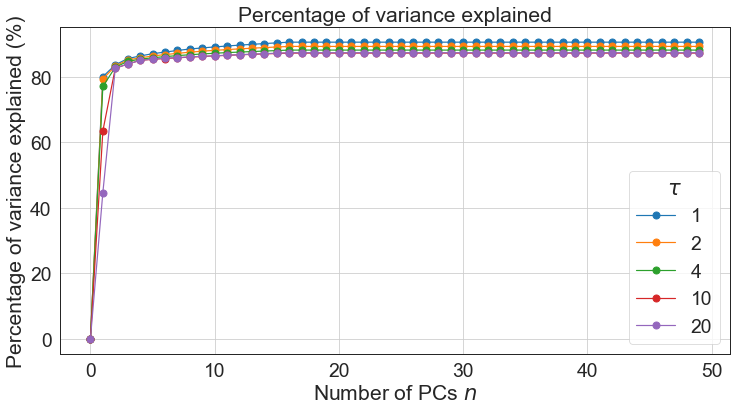

In [3]:
# Percentage of variance explained/ MSE


sns.set_context("paper", font_scale=2.2)
fig = plt.figure(figsize=(12,6))
plt.title(r'Percentage of variance explained')
plt.xlabel(r'Number of PCs $n$')
plt.ylabel(r'Percentage of variance explained (%)')

plt.grid()
for error, freq in zip(error_list,freq_list):
    plt.plot(list(range(50)),[100*e for e in error],'o-', label=freq, markersize=7)
plt.legend(title=r'$\tau$')

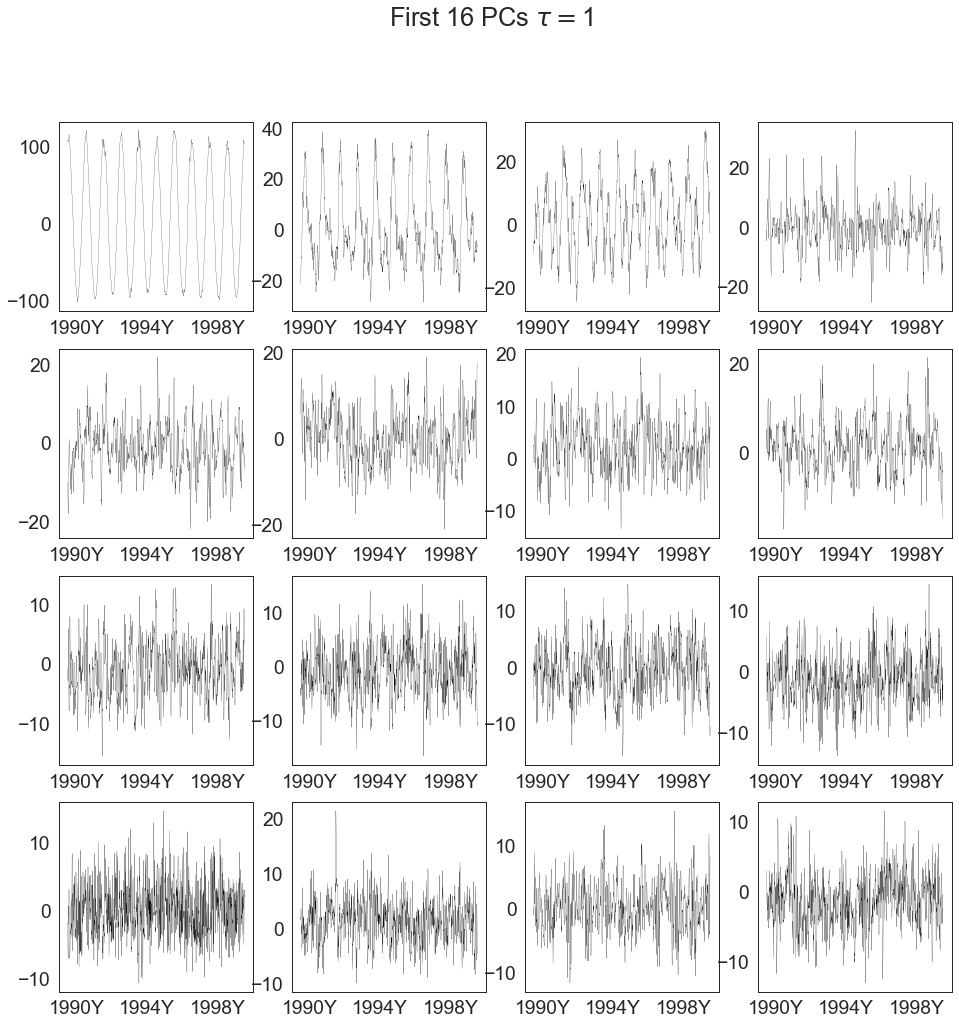

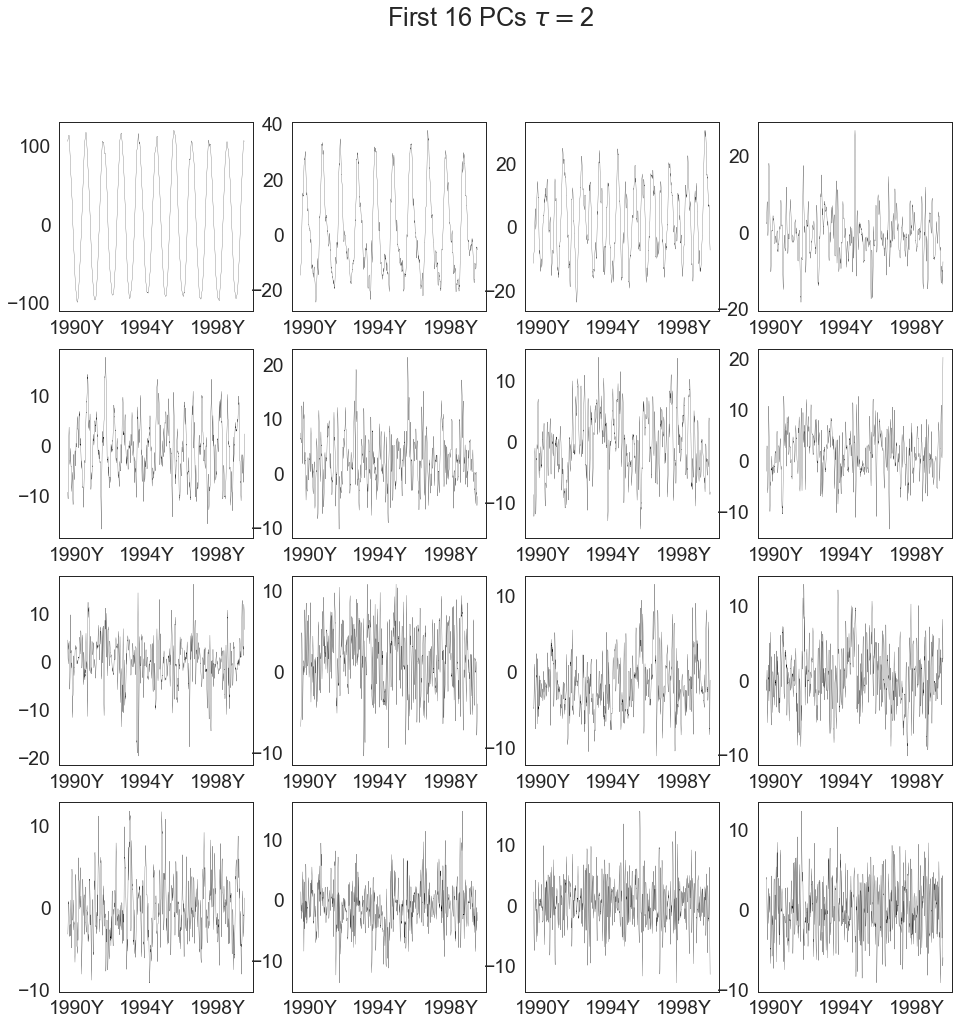

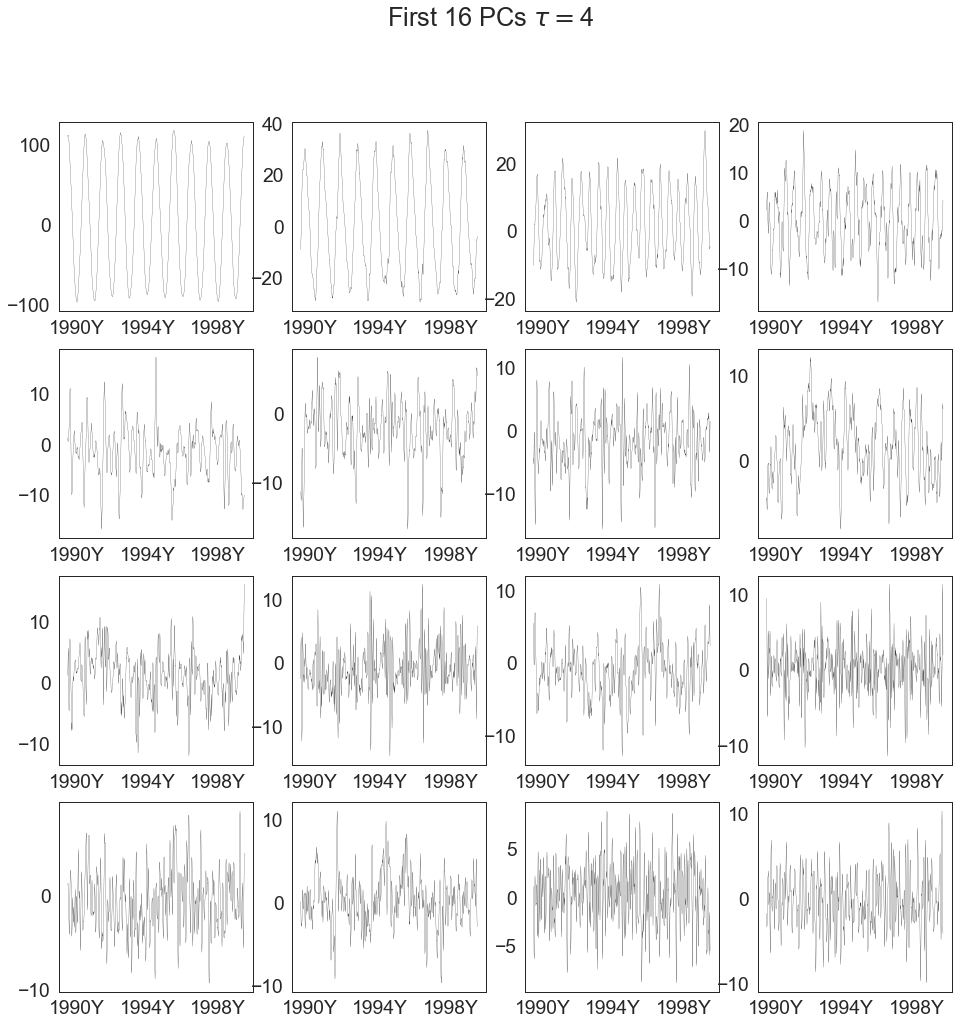

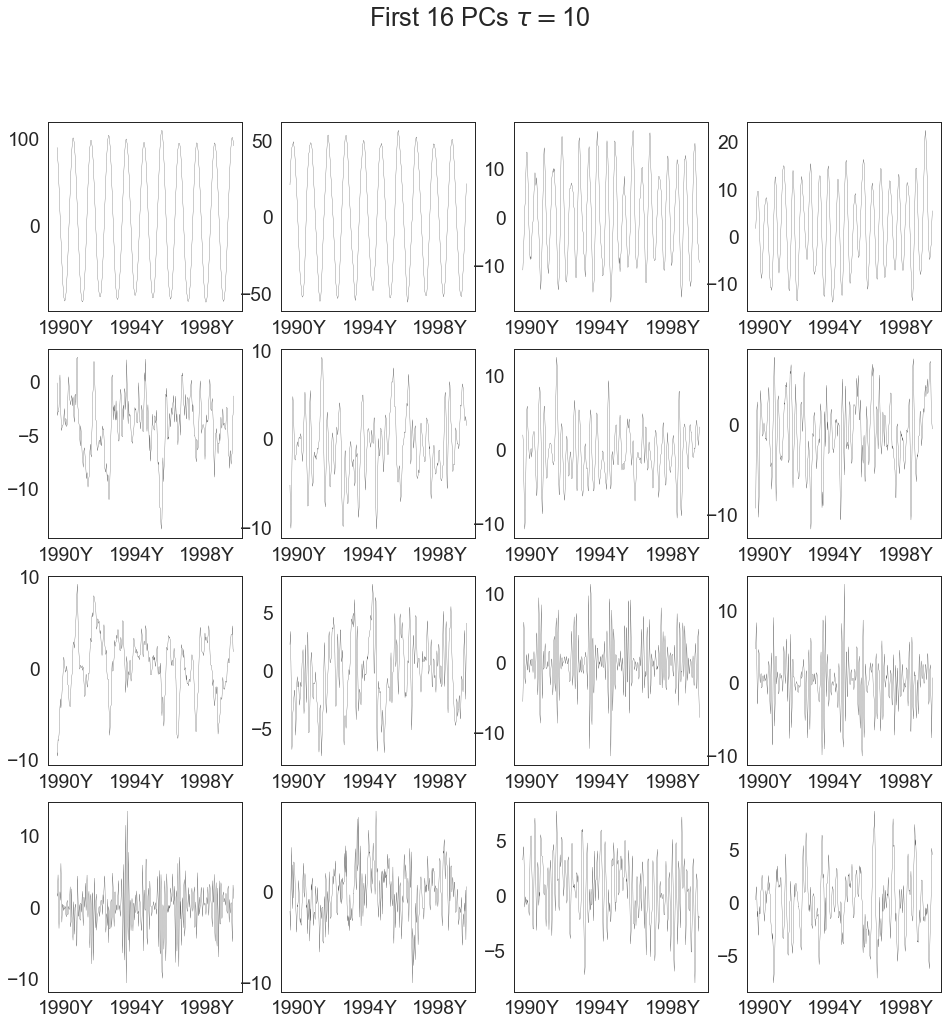

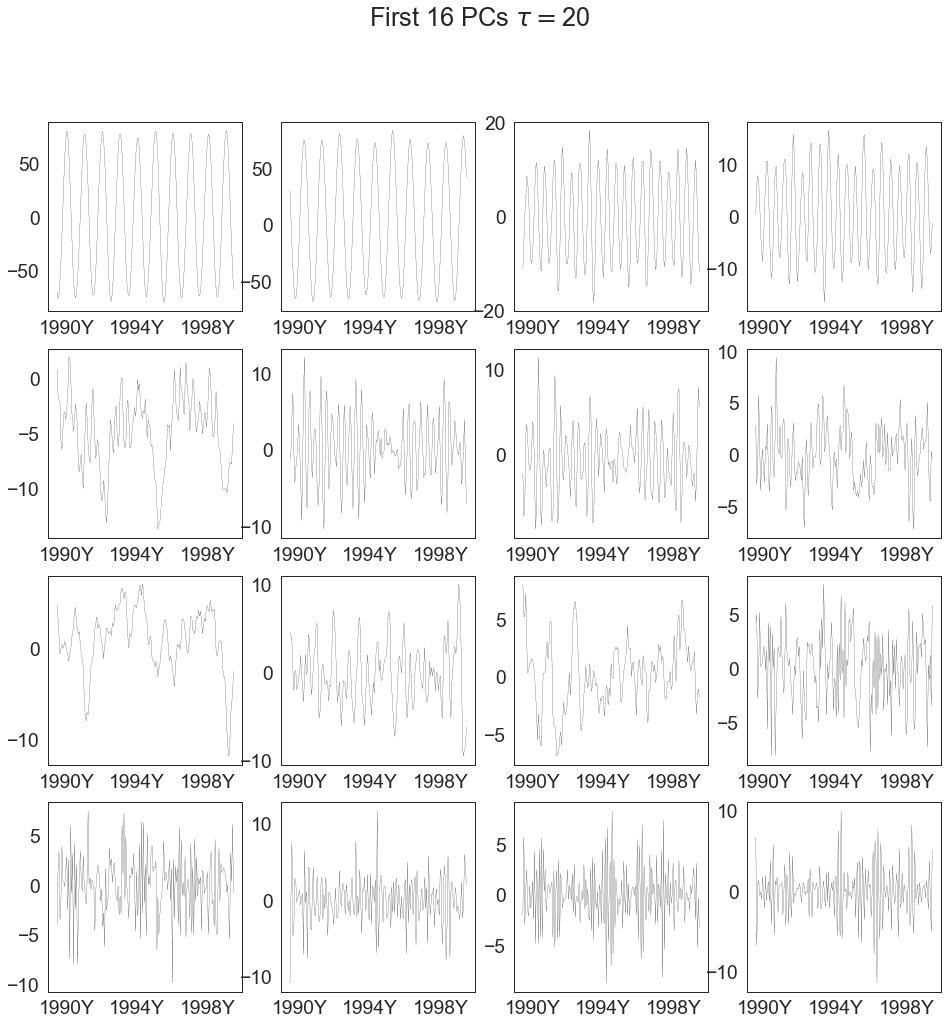

In [4]:
# First b=16 PCs, 10 years 1990-2000
import matplotlib.dates as mdates

b=16
sns.set_context("paper", font_scale=2.2)
for embeddings, freq in zip(embeddings_list,freq_list):
    t = np.arange(datetime.datetime(1990, 1, 1),
                datetime.datetime(1999, 12, 31),
                datetime.timedelta(days=freq))
    # # start= 0*365
    # num_years= 10
    to_plot= embeddings[:len(t)]
   
    
    fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
    fig.suptitle(fr'First 16 PCs $\tau=${freq}')

    for i in range(b):
        ax[int(i/4), i%4].plot(t, to_plot[:,i], 'k', linewidth=.2)
        ax[int(i/4), i%4].xaxis.set_major_locator(mdates.DayLocator(interval=365*4))
        ax[int(i/4), i%4].xaxis.set_major_formatter(mdates.DateFormatter('%YY')) 
    fig.savefig(f"16PCs_Climate_lag6_tau{freq}.png")

## Effect of number of lags $n$

In [5]:
scale = 0.25
lags_list = [1,2,4,6]
freq =10
error_list = []
embeddings_list = []


for lags in lags_list:
    # load data
    X, Xclean, m, n = data_from_name("climate", freq=freq, start_year=1990, end_year= 2030, tropical=0, scale=scale)

    print(type(X))

    X = torch.from_numpy(X).float().contiguous()
    X = add_channels(X)
    print(X.min())
    print(X.max())
    print(X.mean())
    print(X.std())
    

    # normlize and remove mean
    X_nolag = normalize(X,norm_scheme=0) 
    print(X_nolag.min())
    print(X_nolag.max())
    print(X_nolag.mean())
    print(X_nolag.std())

    # add lags
    X_lags = add_lags(X_nolag, lags, freq=1) # to change if needed
    print(X_lags.shape)

    # reshape and do PCA
    del X
    b = 16
    X_f = X_lags.reshape((X_lags.shape[0],-1))
    pca = PCA(n_components=b)
    pca.fit(X_f)
    embeddings =pca.transform(X_f)
    del X_f
    embeddings_list.append(embeddings)

    # calculate errors for different number of PCs
    error=[]
    
    for b in range(50):
        X_red= np.dot(embeddings[:,:b],pca.components_[:b])
        error.append(X_red.std()**2)
    error_list.append(error)

<class 'numpy.ndarray'>
(1461, 18, 36)
<class 'numpy.ndarray'>
tensor(204.8310)
tensor(313.6670)
tensor(279.0221)
tensor(20.6662)
tensor(-5.7089)
tensor(4.5796)
tensor(-1.4647e-07)
tensor(1.)
torch.Size([1461, 18, 36])
<class 'numpy.ndarray'>
(1461, 18, 36)
<class 'numpy.ndarray'>
tensor(204.8310)
tensor(313.6670)
tensor(279.0221)
tensor(20.6662)
tensor(-5.7089)
tensor(4.5796)
tensor(-1.4647e-07)
tensor(1.)
torch.Size([1460, 36, 36])
<class 'numpy.ndarray'>
(1461, 18, 36)
<class 'numpy.ndarray'>
tensor(204.8310)
tensor(313.6670)
tensor(279.0221)
tensor(20.6662)
tensor(-5.7089)
tensor(4.5796)
tensor(-1.4647e-07)
tensor(1.)
torch.Size([1458, 72, 36])
<class 'numpy.ndarray'>
(1461, 18, 36)
<class 'numpy.ndarray'>
tensor(204.8310)
tensor(313.6670)
tensor(279.0221)
tensor(20.6662)
tensor(-5.7089)
tensor(4.5796)
tensor(-1.4647e-07)
tensor(1.)
torch.Size([1456, 108, 36])


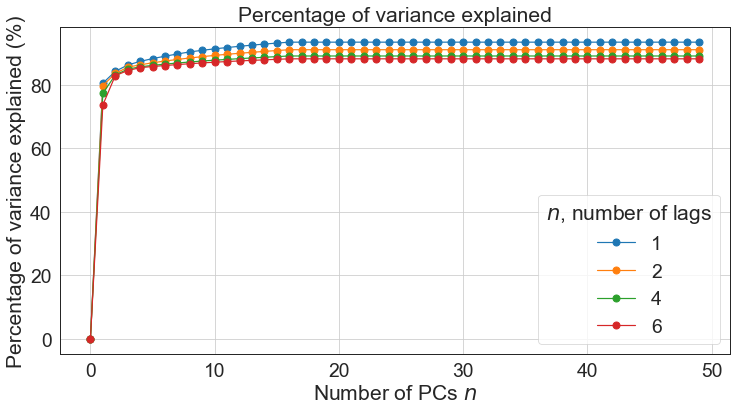

In [6]:
sns.set_context("paper", font_scale=2.2)
fig = plt.figure(figsize=(12,6))
plt.title(r'Percentage of variance explained')
plt.xlabel(r'Number of PCs $n$')
plt.ylabel(r'Percentage of variance explained (%)')

plt.grid()
for error, lags in zip(error_list,lags_list):
    plt.plot(list(range(50)),[100*e for e in error],'o-', label=lags, markersize=7)
plt.legend(title=r'$n$, number of lags')

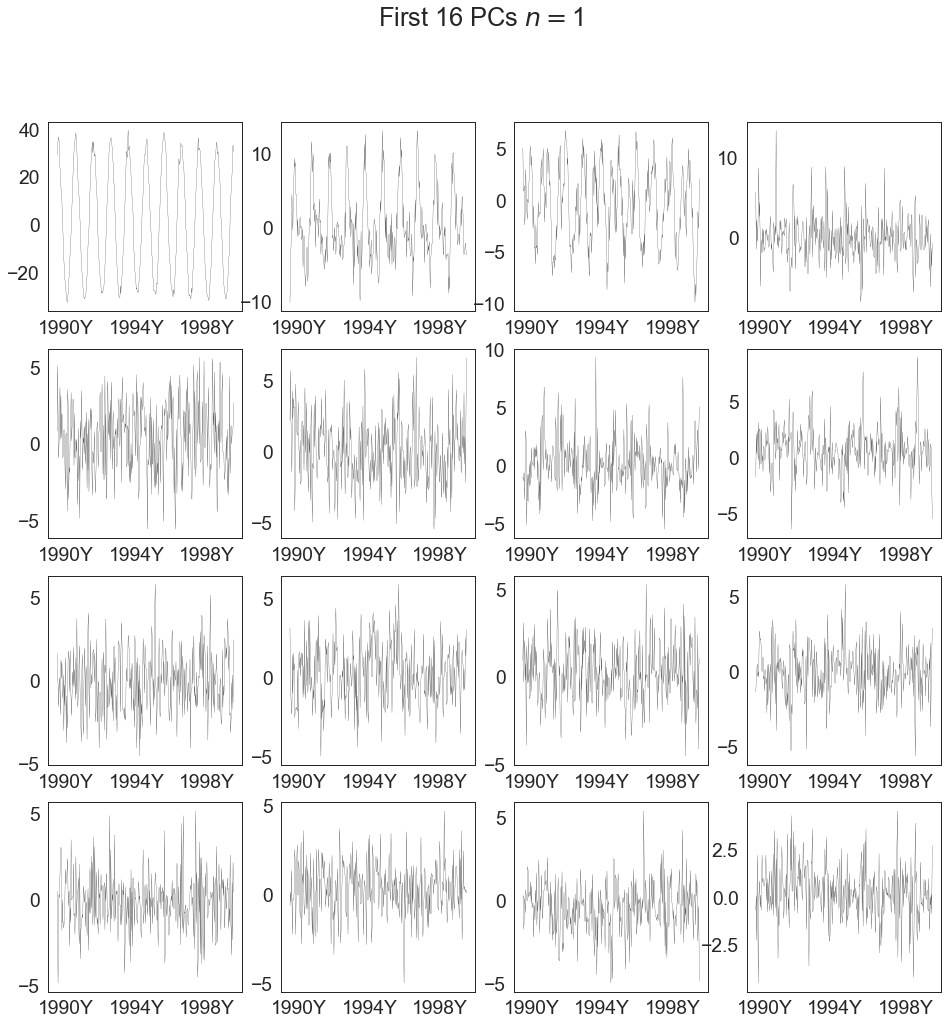

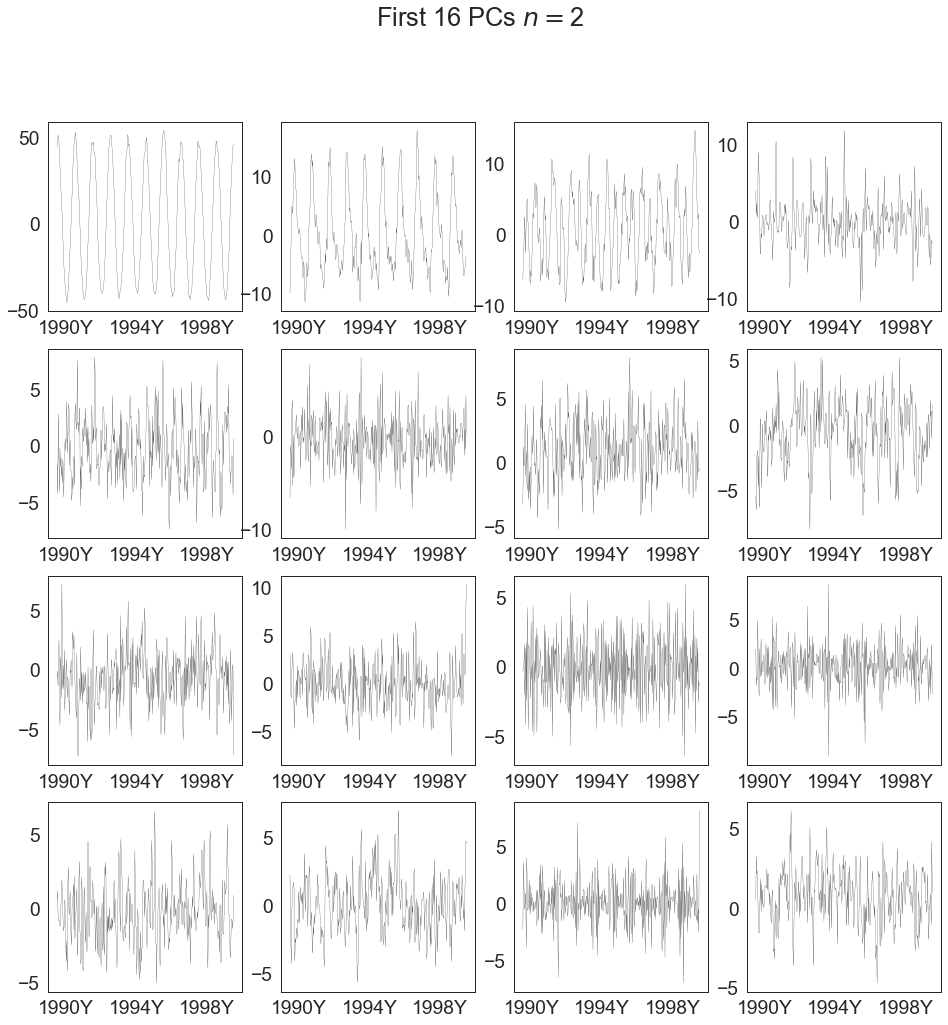

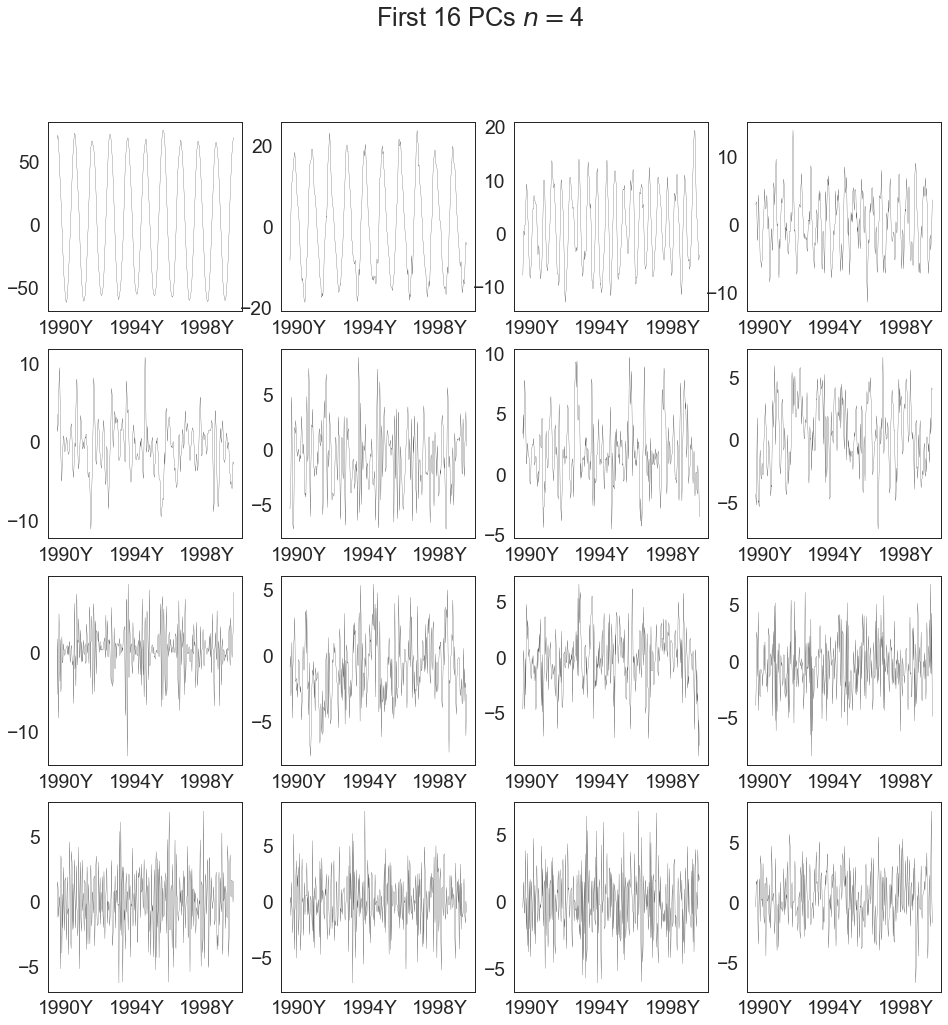

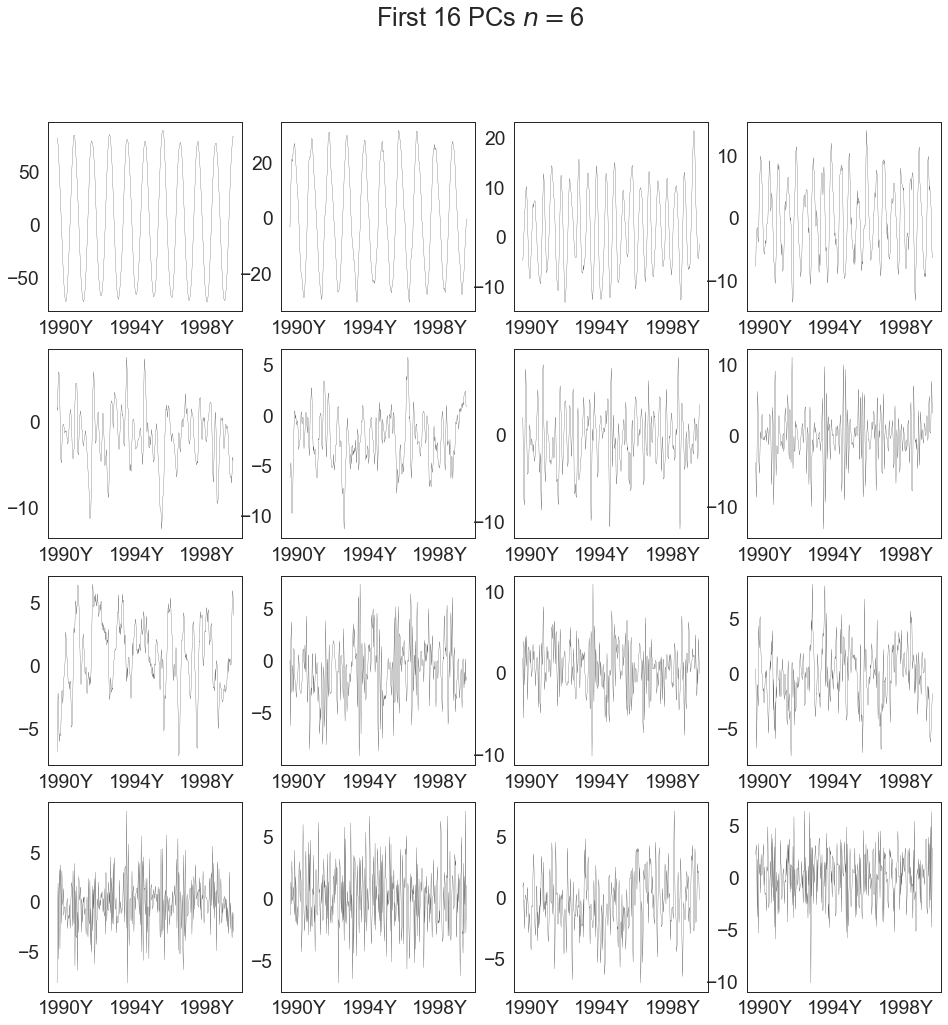

In [7]:
# First b=16 PCs, 10 years 1990-2000
import matplotlib.dates as mdates

b=16
sns.set_context("paper", font_scale=2.2)
for embeddings, lags in zip(embeddings_list,lags_list):
    t = np.arange(datetime.datetime(1990, 1, 1),
                datetime.datetime(1999, 12, 31),
                datetime.timedelta(days=freq))
    # # start= 0*365
    # num_years= 10
    to_plot= embeddings[:len(t)]
   
    
    fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
    fig.suptitle(fr'First 16 PCs $n=${lags}')

    for i in range(b):
        ax[int(i/4), i%4].plot(t, to_plot[:,i], 'k', linewidth=.2)
        ax[int(i/4), i%4].xaxis.set_major_locator(mdates.DayLocator(interval=365*4))
        ax[int(i/4), i%4].xaxis.set_major_formatter(mdates.DateFormatter('%YY')) 
    fig.savefig(f"16PCs_Climate_lag6_n{lags}.png")

## Global warming

In [10]:
scale = 0.25
lags = 6
freq =10

# load data
X, Xclean, m, n = data_from_name("climate", freq=freq, start_year=1870, end_year= 2030, tropical=0, scale=scale)

print(type(X))

X = torch.from_numpy(X).float().contiguous()
X = add_channels(X)
print(X.min())
print(X.max())
print(X.mean())
print(X.std())


# normlize and remove mean
X_nolag = normalize(X,norm_scheme=0) 
print(X_nolag.min())
print(X_nolag.max())
print(X_nolag.mean())
print(X_nolag.std())

# add lags
X_lags = add_lags(X_nolag, lags, freq=1)
print(X_lags.shape)

# reshape and do PCA
del X
b = 16
X_f = X_lags.reshape((X_lags.shape[0],-1))
pca = PCA(n_components=b)
pca.fit(X_f)
embeddings =pca.transform(X_f)
del X_f


<class 'numpy.ndarray'>
(5844, 18, 36)
<class 'numpy.ndarray'>
tensor(202.9319)
tensor(313.6670)
tensor(278.1489)
tensor(20.8434)
tensor(-6.0607)
tensor(4.6887)
tensor(-1.2997e-07)
tensor(1.)
torch.Size([5839, 108, 36])


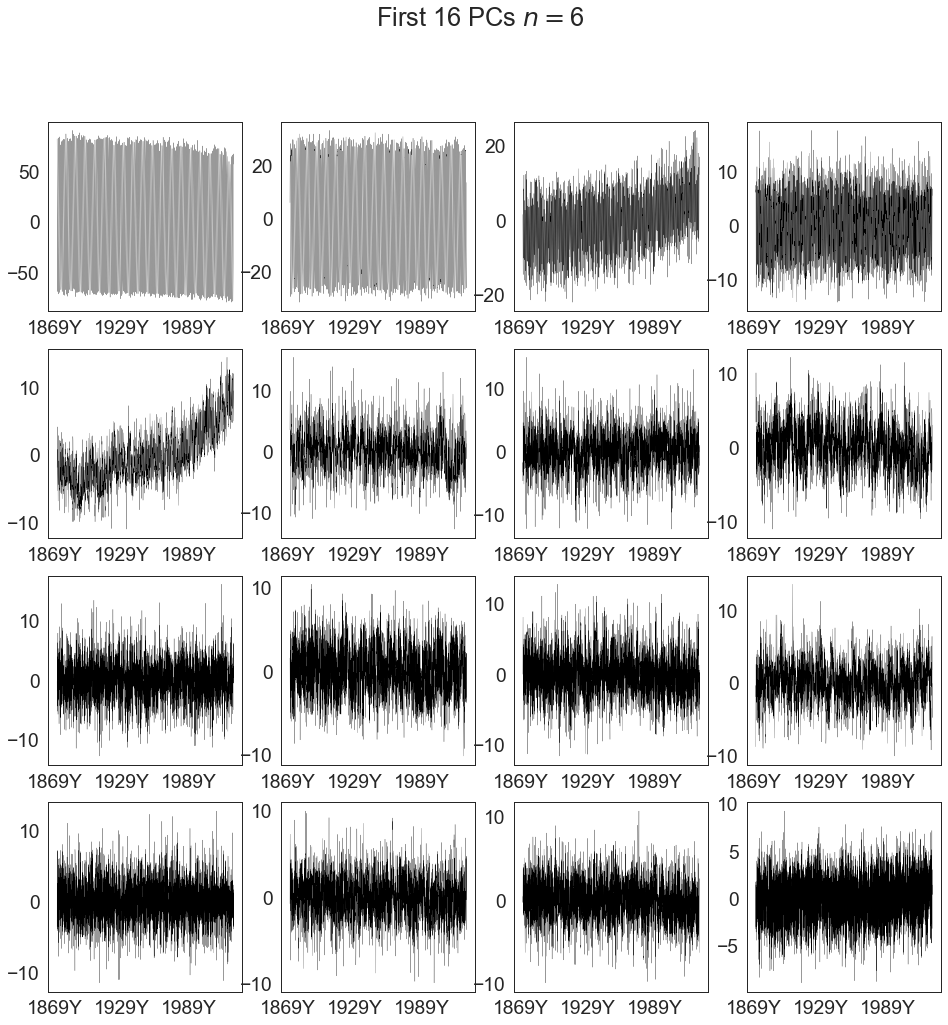

In [11]:
import matplotlib.dates as mdates

b=16
sns.set_context("paper", font_scale=2.2)
    
t = np.arange(datetime.datetime(1870, 12, 31),
            datetime.datetime(2029, 1, 31),
            datetime.timedelta(days=freq))
# # start= 0*365
# num_years= 10
to_plot= embeddings[:len(t)]


fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
fig.suptitle(fr'First 16 PCs $n=${lags}')

for i in range(b):
    ax[int(i/4), i%4].plot(t, to_plot[:,i], 'k', linewidth=.2)
    ax[int(i/4), i%4].xaxis.set_major_locator(mdates.DayLocator(interval=365*60))
    ax[int(i/4), i%4].xaxis.set_major_formatter(mdates.DateFormatter('%YY')) 
fig.savefig(f"16PCs_Climate_lag6_n{lags}_whole_period.png")

## $n=30$ lags

In [8]:
scale = 0.25
lags = 30
freq =10

# load data
X, Xclean, m, n = data_from_name("climate", freq=freq, start_year=1990, end_year= 2030, tropical=0, scale=scale)

print(type(X))

X = torch.from_numpy(X).float().contiguous()
X = add_channels(X)
print(X.min())
print(X.max())
print(X.mean())
print(X.std())


# normlize and remove mean
X_nolag = normalize(X,norm_scheme=0) 
print(X_nolag.min())
print(X_nolag.max())
print(X_nolag.mean())
print(X_nolag.std())

# add lags
X_lags = add_lags(X_nolag, lags, freq=1)
print(X_lags.shape)

# reshape and do PCA
del X
b = 16
X_f = X_lags.reshape((X_lags.shape[0],-1))
pca = PCA(n_components=b)
pca.fit(X_f)
embeddings =pca.transform(X_f)
del X_f


<class 'numpy.ndarray'>
(1461, 18, 36)
<class 'numpy.ndarray'>
tensor(204.8310)
tensor(313.6670)
tensor(279.0221)
tensor(20.6662)
tensor(-5.7089)
tensor(4.5796)
tensor(-1.4647e-07)
tensor(1.)
torch.Size([1432, 540, 36])


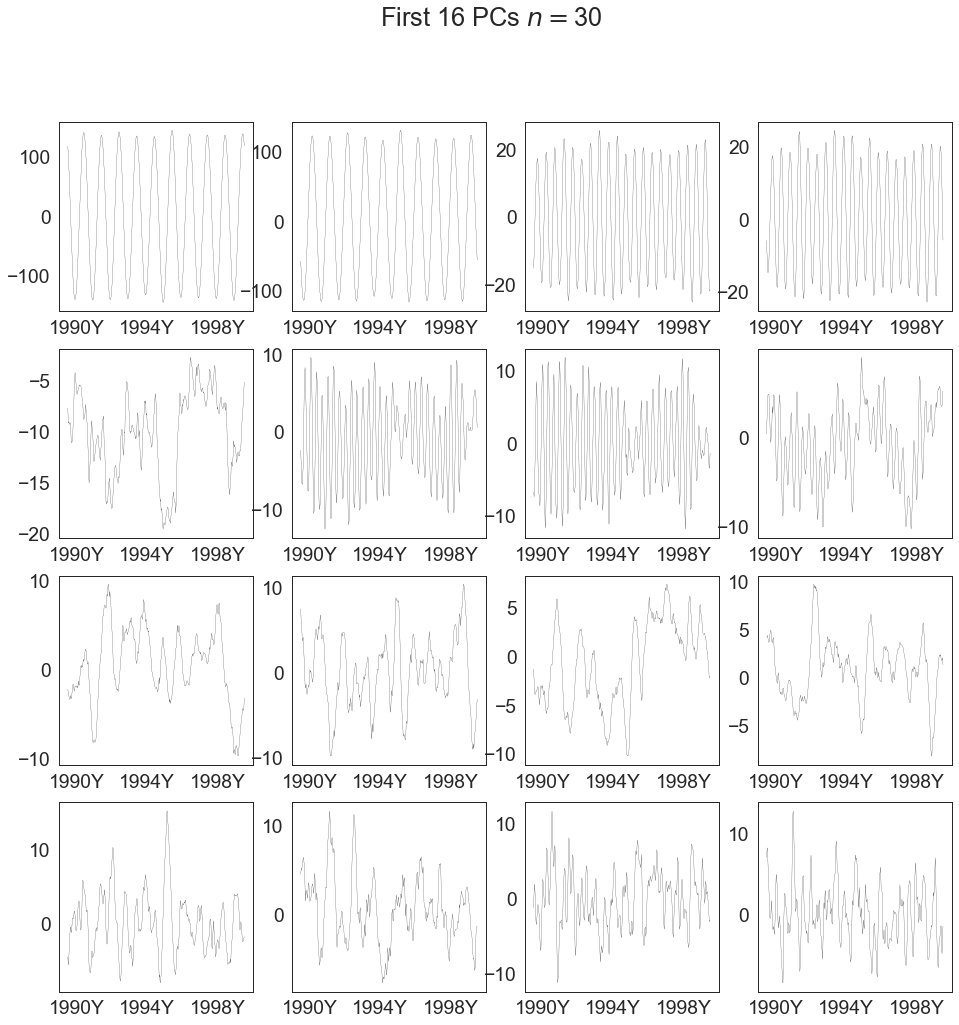

In [9]:
import matplotlib.dates as mdates

b=16
sns.set_context("paper", font_scale=2.2)
    
t = np.arange(datetime.datetime(1990, 1, 1),
                datetime.datetime(1999, 12, 31),
                datetime.timedelta(days=freq))
# # start= 0*365
# num_years= 10
to_plot= embeddings[:len(t)]


fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
fig.suptitle(fr'First 16 PCs $n=${lags}')

for i in range(b):
    ax[int(i/4), i%4].plot(t, to_plot[:,i], 'k', linewidth=.2)
    ax[int(i/4), i%4].xaxis.set_major_locator(mdates.DayLocator(interval=365*4))
    ax[int(i/4), i%4].xaxis.set_major_formatter(mdates.DateFormatter('%YY')) 
fig.savefig(f"16PCs_Climate_lag6_n{lags}.png")

## Daily data with 5 year lags

In [16]:
scale = 1
lags = 180
freq = 1



# load data
X, Xclean, m, n = data_from_name("climate", freq=freq, start_year=1970, end_year= 1980, tropical=0, scale=scale)

print(type(X))

X = torch.from_numpy(X).float().contiguous()
X = add_channels(X)
print(X.min())
print(X.max())
print(X.mean())
print(X.std())

if False:
    # normlize and remove mean
    X_nolag = normalize(X,norm_scheme=0) 
    print(X_nolag.min())
    print(X_nolag.max())
    print(X_nolag.mean())
    print(X_nolag.std())

# add lags
X_lags = add_lags(X, lags, freq=1) # to change if needed
print(X_lags.shape)





<class 'numpy.ndarray'>
(3652, 72, 144)
<class 'numpy.ndarray'>
tensor(194.4736)
tensor(319.6931)
tensor(278.1541)
tensor(21.4194)


RuntimeError: [enforce fail at CPUAllocator.cpp:67] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 25925806080 bytes. Error code 12 (Cannot allocate memory)

In [11]:
# reshape and do PCA
del X
b = 50
X_f = X_lags.reshape((X_lags.shape[0],-1))
print(X_f.shape)

torch.Size([2013, 116640])


In [12]:
%timeit
pca = PCA(n_components=b)
pca.fit(X_f)
embeddings =pca.transform(X_f)
del X_f



In [7]:
# calculate errors for different number of PCs

for b in range(50):
    X_red= np.dot(embeddings[:,:b],pca.components_[:b])
    error.append(X_red.std()**2)
    error_list.append(error)

KeyboardInterrupt: 

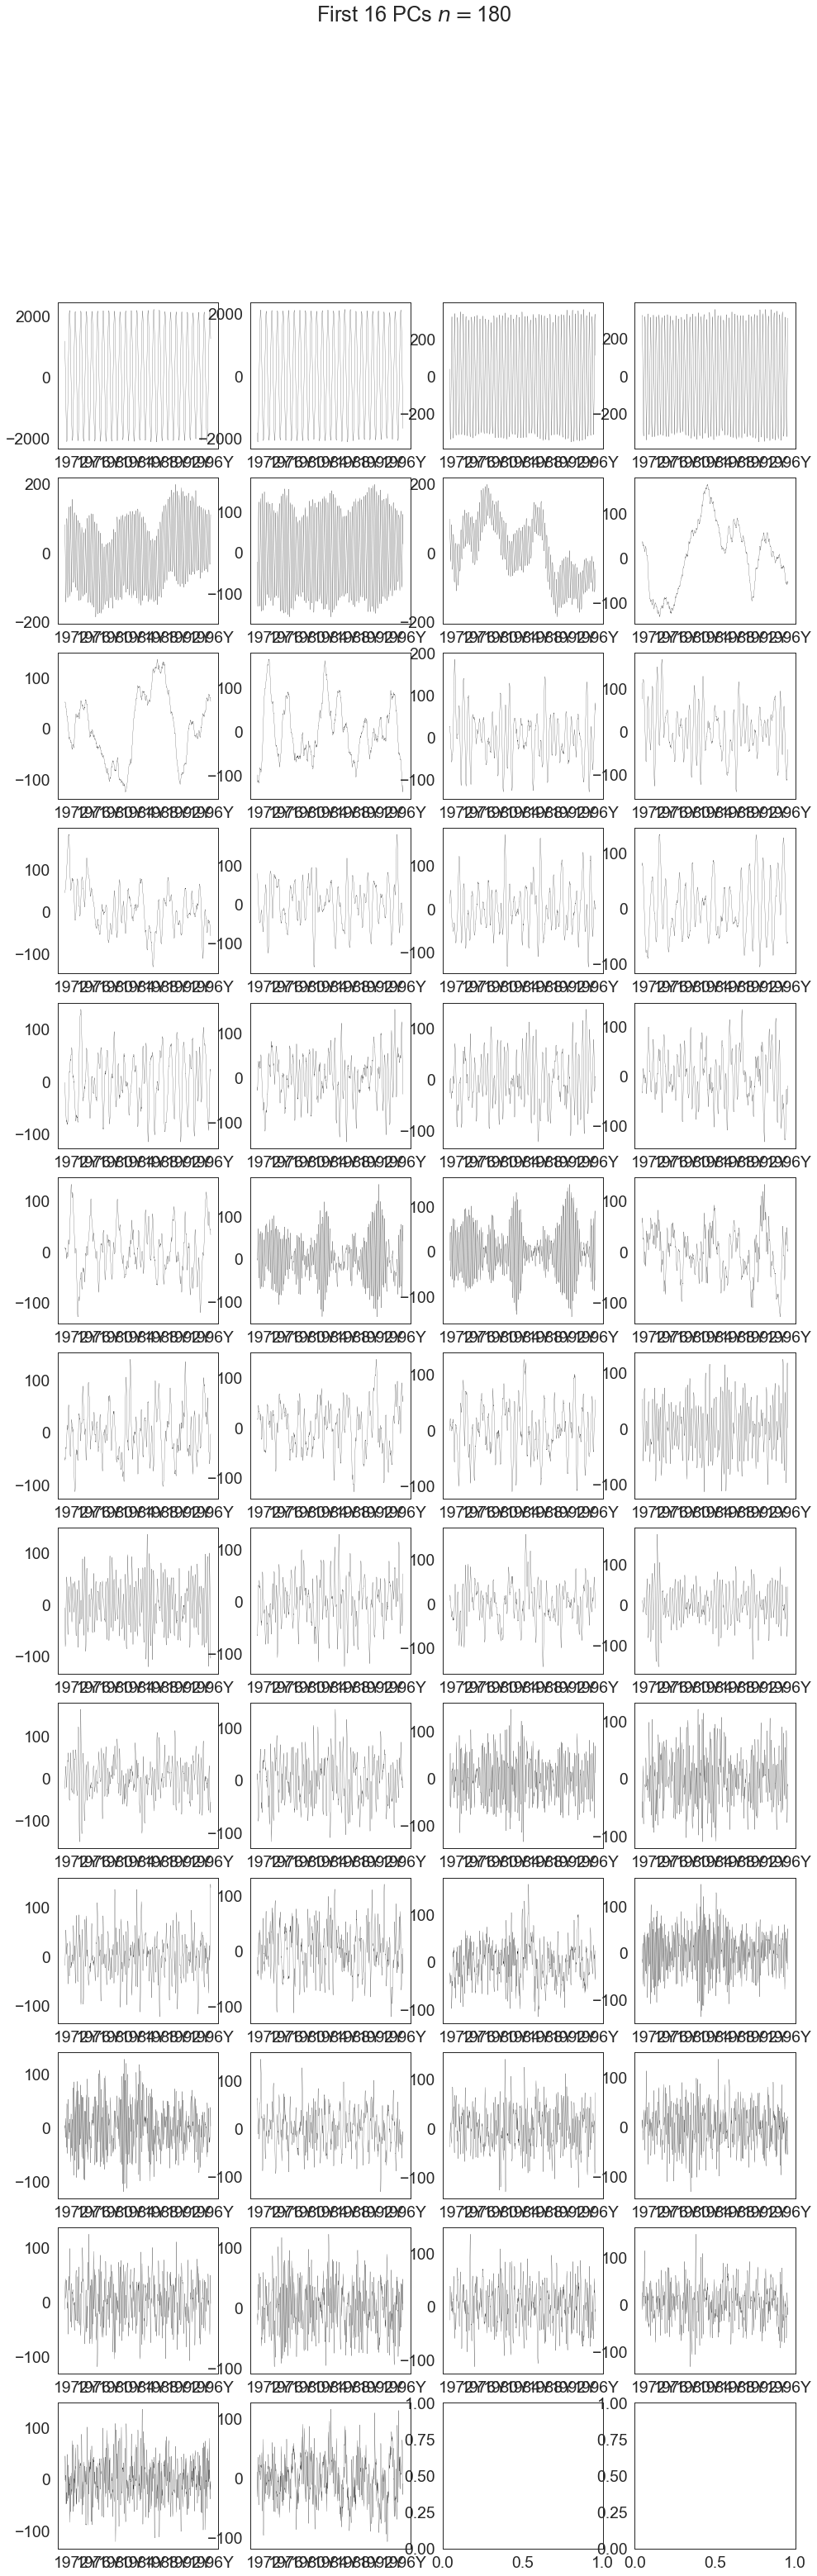

In [15]:
%timeit 
import matplotlib.dates as mdates

b=50
sns.set_context("paper", font_scale=2.2)
    
t = np.arange(datetime.datetime(1970, 1, 1),
                datetime.datetime(1995, 12, 31),
                datetime.timedelta(days=freq))
# # start= 0*365
# num_years= 10
to_plot= embeddings[:len(t)]


fig, ax = plt.subplots(nrows=math.ceil(b/4), ncols=4, figsize=(16,b))
fig.suptitle(fr'First 16 PCs $n=${lags}')

for i in range(b):
    ax[int(i/4), i%4].plot(t, to_plot[:,i], 'k', linewidth=.2)
    ax[int(i/4), i%4].xaxis.set_major_locator(mdates.DayLocator(interval=365*4))
    ax[int(i/4), i%4].xaxis.set_major_formatter(mdates.DateFormatter('%YY')) 